<a href="https://colab.research.google.com/github/nihotoa/EMG_analysis/blob/main/Trial_private.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Project Name    : Machine Learning

 File Name       : Trial.ipynb

 Creation Date   : Jun 9 2021

 Modify Date     : Jun 2 2023

 Copyright (c) 2021 KAMAKE no SUSUME. All rights reserved.

 This source code or any portion thereof must not be reproduced or used in any manner whatsoever.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab/Trial

/content/drive/MyDrive/Colab/Trial


画像を訓練用と検証用に分割する(4:1の割合)

In [ ]:
%run prepare_images.py datasets/dice_top_crop

Copied images from datasets/dice_top_crop/1
Copied images from datasets/dice_top_crop/2
Copied images from datasets/dice_top_crop/3
Copied images from datasets/dice_top_crop/4
Copied images from datasets/dice_top_crop/5
Copied images from datasets/dice_top_crop/6


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import shutil
import math
from IPython.display import Image as IPImage
from IPython.display import display_jpeg
# 可視化用コードvisualize.pyのimport
import visualize

print(tf.__version__) #tensorflowのバージョン確認
# train画像のdirのpath
train_dir = 'target_datasets/train'
# val(評価)画像のdirのpath
val_dir = 'target_datasets/val'

backup_dir = './model'

# ディレクトリ名からラベル値(1~6)を自動で作る
labels = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))] #dがディレクトリだった場合は，ディレクトリ名を取得
labels.sort()

# backup_dirが存在する場合,backup_dirを消去する
if os.path.exists(backup_dir):
    shutil.rmtree(backup_dir)

# backup_dirを作る
os.makedirs(backup_dir)

# labels.txtを書き込みモードで開く(作成)
with open(backup_dir + '/labels.txt','w') as f:
    for label in labels:
        # labelを書き込んで改行
        f.write(label+"\n")

NUM_CLASSES = len(labels)
print("class number=" + str(NUM_CLASSES))


labels = []
#labels.txtを読み込みモードで開く
with open(backup_dir + '/labels.txt','r') as f:
    for line in f: #txtの各行をiterationする
        # 各行の内容をlabelsにappendする(\nは無視する)
        labels.append(line.rstrip())
print(labels)

2.14.0
class number=6
['1', '2', '3', '4', '5', '6']


Found 72 images belonging to 6 classes.
Found 22 images belonging to 6 classes.
## Train Data Sample ##


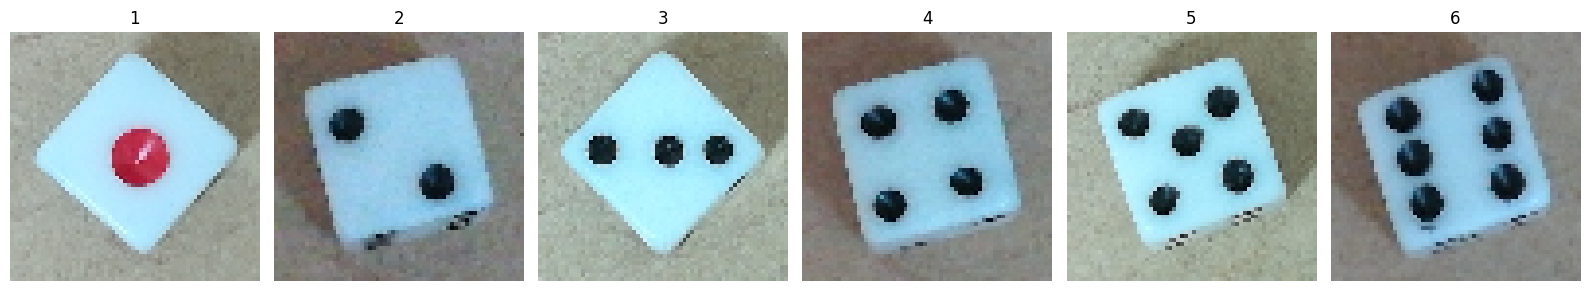


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



--Return--
None
> <ipython-input-4-92d22f3e63d7>(103)<cell line: 103>()
    101 
    102 #モデル作成終了のブレークポイント
--> 103 breakpoint()
    104 
    105 # 学習の実行,学習と制度の表示

ipdb> c



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 347, in set_continue
    sys.settrace(None)



--Return--
None
> <ipython-input-4-92d22f3e63d7>(110)<cell line: 110>()
    108 #opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)
    109 
--> 110 breakpoint()
    111 
    112 # 実際にモデルを構築

ipdb> type(opt)
<class 'keras.src.optimizers.adam.Adam'>
ipdb> c
--Return--
None
> <ipython-input-4-92d22f3e63d7>(116)<cell line: 116>()
    114     metrics=['accuracy'])
    115 
--> 116 breakpoint()
    117 
    118 # 構築したモデルの概要を見る

ipdb> model.summary()
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 8)         0         
 D)                                                          

In [ ]:
# パラメータ設定

# 学習率(勾配法で重みを変更するときの定数の大きさ)
LEARNING_RATE = 0.005
# エポック（世代数）
EPOCHS = 20
# バッチサイズ
BATCH_SIZE = 8
# 画像のリサイズ(IMAGE_SIZE*IMAGE_SIZEの形にする)
IMAGE_SIZE = 64

# コード部分
"""
ImageDataGeneratorクラスからインスタンスを生成
(rescaleを指定して,このインスタンスの引数の画像のRGB値を正規化するようにしている)
rescale以外の引数についても調べる & インスタンスにどんなメソッドが用意されているのか調べる
生成されるデータのデータ型 => <class 'keras.src.preprocessing.image.ImageDataGenerator'>
"""
train_data_gen = ImageDataGenerator(rescale=1./255) # 画像のRGB値の正規化(ImageDataGeneratorが正規化を担っている)
#train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=180) #rotation_rangeは画像を回転させるための引数
val_data_gen = ImageDataGenerator(rescale=1./255)

# メモ：ImageDataGenerator.flow_from_directory はIteratorを返す
"""
インスタンスを生成(ディレクトリから画像を読み込み, 色々前処理を行なっている)
flow_from_directory:画像の読み込みとデータ拡張を行うメソッド(ImageDataGeneratorのメソッド)
train_dir: 画像のあるディレクトリの指定(1~6の各12枚の画像が入っているディレクトリ)
target_size: 画像のサイズの指定(タプル)
color_mode: 'rgb'でおけ(変える必要なし)
batch_size:バッチサイズの指定(8なら，8枚を1グループとして考える.この数によってiterationの数も変わってくる)
(?)class_mode:ラベルの種類の指定
shuffle:データをシャッフルするかどうか, (モデルがデータの順序の影響を受けにくくなる)
生成されるデータのデータ型 => <class 'keras.src.preprocessing.image.DirectoryIterator'>
"""
train_data = train_data_gen.flow_from_directory(
    train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True)

# 評価用のデータの画像にも同じ前処理をする(こっちはshuffleしない)
validation_data = val_data_gen.flow_from_directory(
    val_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode='rgb', batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False)

# Display train data sample
# 入力画像のうち,各ラベル1枚ずつ表示
visualize.pick_train_sample(labels, train_data)

# AI model definition(学習モデルの構築)
# Sequential: tensorflowにおいて,ニューラルネットワークの層を直線的に積み重ねていくためのモデル構築クラス.
model = Sequential() # 線形モデルでモデルを構築

"""
ヒント: model.add()の引数でモデルを構築していくっぽい
model.summary()で各層の出力形状などのモデルの内部に関する情報を見れる
addやsummaryはSequentialクラスに用意されているメソッド
"""

# 1回目の畳み込み
"""
conv2D => 畳み込みのためのメソッド
【引数】
フィルターの枚数
フィルターのサイズ
padding:same(入力と畳み込み結果の行列サイズが等しくなるようにゼロパディングを行う)
input_shape: タプル,入力データの形状指定(RGBなので最後が3)
"""
model.add(Conv2D(8, (3, 3), padding='same',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

# 活性化関数としてrelu関数を用いる(以降も同じ)
model.add(Activation('relu'))

# プーリング(1回目)(プーリング処理後は活性化関数通さなくていい？)
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2回目の畳み込み(8 => フィルタの枚数, 3 => フィルタのサイズ(3*3))
model.add(Conv2D(8, (3, 3), padding='same',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))

model.add(Activation('relu'))

# プーリング(2回目)
model.add(MaxPooling2D(pool_size=(2, 2)))

# 第1層から第２層へのドロップアウト率を指定する(25%の重みを無視する)
model.add(Dropout(0.25))

# 行列をベクトルにする(第2層に全結合するために1列に並べる)
model.add(Flatten())

# 第2層に全結合(第2層のノード数はDenceの引数)
model.add(Dense(128))
model.add(Activation('relu'))

# 第２層から出力層に全結合(出力層のノード数は6(サイコロの出目の数))
model.add(Dense(NUM_CLASSES))
# 出力層は活性化関数にsoftmaxを用いる
model.add(Activation('softmax'))

#モデル作成終了のブレークポイント
breakpoint()

# 学習の実行,学習と制度の表示
#最適化アルゴリズムの設定(勾配法はadam, 先ほどのLEARNING_RATEを指定する)
opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
#opt = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE)

breakpoint()

# 実際にモデルを構築
"""
3つの引数が必要
optimizar:  重み更新のアルゴリズム(adamは勾配降下方法)
損失関数: 予測値と実測値のずれを計算するための関数.
(categorical_crossentropy: 多クラス分類に使われる損失関数の一つ, [1,0,0,0,0,0] みたいな感じで出力される)
評価指標: モデルの性能を評価するための指標(分類ならaccuracyでいい)
"""
model.compile(opt, loss='categorical_crossentropy',
    metrics=['accuracy'])

breakpoint()

# 構築したモデルの概要を見る
model.summary()

# Execute train(学習の実行)
"""
historyは学習過程の詳細が格納されている
fitメソッドのコールバック関数
historyクラスの変数及びメソッド
変数
.params => dictionaryが買ってくる.{'verbose': 1, 'epochs': 20, 'steps': 9}. varbose:学習ログがあるかどうか,steps: 1エポックあたりのイテレーション回数
.epoch => 現在のエポック数がリストにappendされていく.別にいらない
.history => 損失と指標(accuracy)の各エポックでのログが記録されている. loss, accuracyなどのキーがある
(ex.) history.history['loss'] で各エポックの損失のログが見れる
"""
history = model.fit(train_data, epochs=EPOCHS, validation_data=validation_data, verbose=1)

breakpoint()

# 損失(loss) => 正解値と予測値(モデルによる出力値)とのズレ, 精度(accuracy)の表示
score = model.evaluate(validation_data)

breakpoint()

print('Test loss:', score[0])
print('Test accuracy:', score[1])



3/3 [==============================] - 0s 15ms/step
Prediction data
[[1.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.    0.    0.    0.   ]
 [0.    0.938 0.    0.062 0.    0.   ]
 [0.    0.969 0.001 0.03  0.    0.   ]
 [0.    0.013 0.015 0.971 0.    0.002]
 [0.    0.964 0.    0.035 0.    0.   ]
 [0.012 0.    0.987 0.    0.001 0.   ]
 [0.901 0.    0.092 0.    0.007 0.   ]
 [0.304 0.    0.118 0.    0.577 0.   ]
 [0.092 0.    0.023 0.    0.885 0.   ]
 [0.    0.    0.    0.006 0.    0.993]
 [0.    0.    0.    0.004 0.    0.996]
 [0.    0.226 0.    0.772 0.    0.002]
 [0.    0.    0.    0.882 0.    0.118]
 [0.004 0.    0.    0.    0.985 0.011]
 [0.    0.    0.81  0.    0.189 0.   ]
 [0.    0.    0.045 0.    0.954 0.   ]
 [0.    0.    0.    0.736 0.    0.264]
 [0.    0.    0.    0.011 0.    0.989]
 [0.    0.    0.    0.016 0.    0.984]]
(22, 6)
#0 Expected:1 -> Predicted:1
File: 1/IMG_20210418_174655.jpg
Each

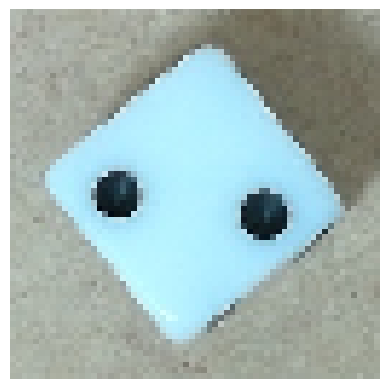

#7 Expected:2 -> Predicted:2
File: 2/IMG_20210418_180634.jpg
Each Prediction Value: [0.    0.964 0.    0.035 0.    0.   ]
* Correct *
#8 Expected:3 -> Predicted:3
File: 3/IMG_20210418_174812.jpg
Each Prediction Value: [0.012 0.    0.987 0.    0.001 0.   ]
* Correct *
#9 Expected:3 -> Predicted:1
File: 3/IMG_20210418_174835.jpg
Each Prediction Value: [0.901 0.    0.092 0.    0.007 0.   ]
**** INCORRECT ****


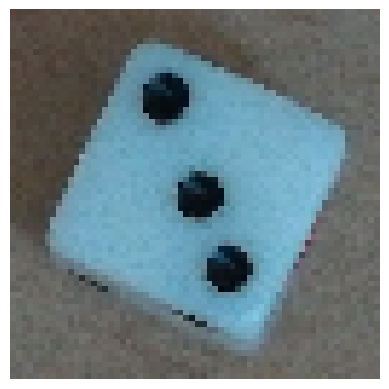

#10 Expected:3 -> Predicted:5
File: 3/IMG_20210418_175038.jpg
Each Prediction Value: [0.304 0.    0.118 0.    0.577 0.   ]
**** INCORRECT ****


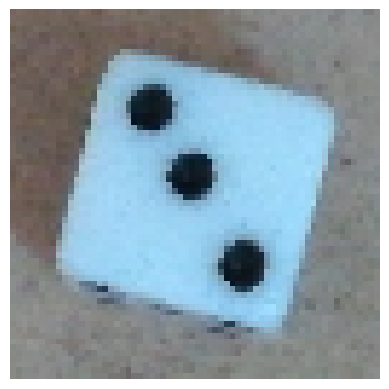

#11 Expected:3 -> Predicted:5
File: 3/IMG_20210418_180703.jpg
Each Prediction Value: [0.092 0.    0.023 0.    0.885 0.   ]
**** INCORRECT ****


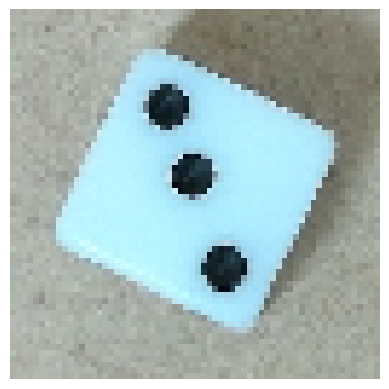

#12 Expected:4 -> Predicted:6
File: 4/IMG_20210418_174900.jpg
Each Prediction Value: [0.    0.    0.    0.006 0.    0.993]
**** INCORRECT ****


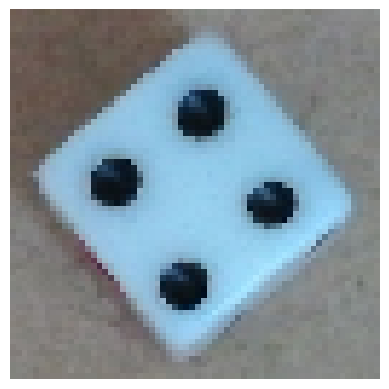

#13 Expected:4 -> Predicted:6
File: 4/IMG_20210418_175106.jpg
Each Prediction Value: [0.    0.    0.    0.004 0.    0.996]
**** INCORRECT ****


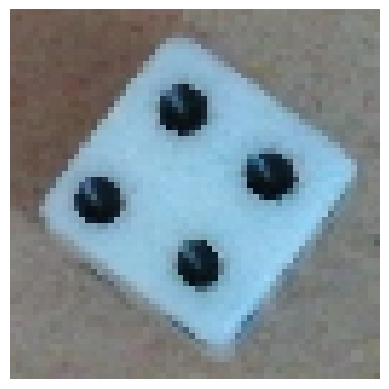

#14 Expected:4 -> Predicted:4
File: 4/IMG_20210418_175112.jpg
Each Prediction Value: [0.    0.226 0.    0.772 0.    0.002]
* Correct *
#15 Expected:4 -> Predicted:4
File: 4/IMG_20210418_180745.jpg
Each Prediction Value: [0.    0.    0.    0.882 0.    0.118]
* Correct *
#16 Expected:5 -> Predicted:5
File: 5/IMG_20210418_174930.jpg
Each Prediction Value: [0.004 0.    0.    0.    0.985 0.011]
* Correct *
#17 Expected:5 -> Predicted:3
File: 5/IMG_20210418_180801.jpg
Each Prediction Value: [0.    0.    0.81  0.    0.189 0.   ]
**** INCORRECT ****


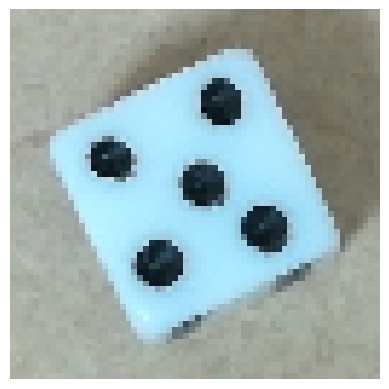

#18 Expected:5 -> Predicted:5
File: 5/IMG_20210418_180812.jpg
Each Prediction Value: [0.    0.    0.045 0.    0.954 0.   ]
* Correct *
#19 Expected:6 -> Predicted:4
File: 6/IMG_20210418_174944.jpg
Each Prediction Value: [0.    0.    0.    0.736 0.    0.264]
**** INCORRECT ****


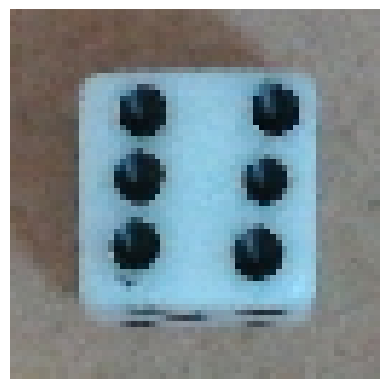

#20 Expected:6 -> Predicted:6
File: 6/IMG_20210418_174949.jpg
Each Prediction Value: [0.    0.    0.    0.011 0.    0.989]
* Correct *
#21 Expected:6 -> Predicted:6
File: 6/IMG_20210418_180859.jpg
Each Prediction Value: [0.    0.    0.    0.016 0.    0.984]
* Correct *
Loss


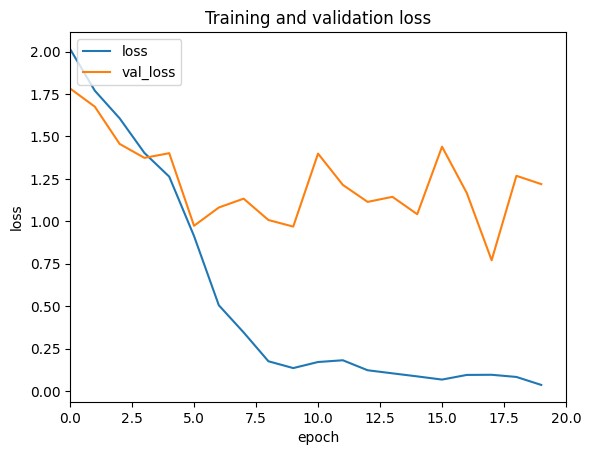

Accuracy


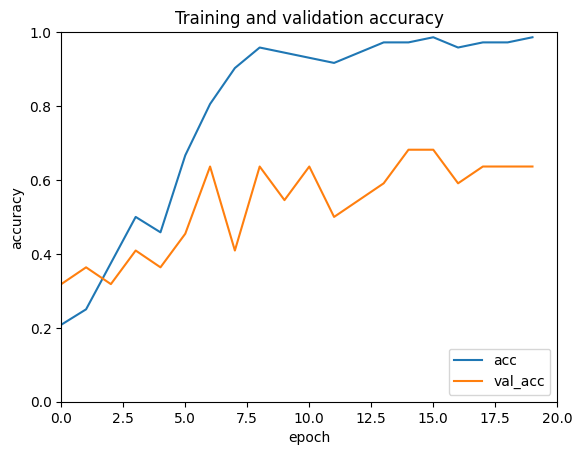

 1/22 [>.............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


22/22 [==============================] - 0s 4ms/step
Confusion Matrix


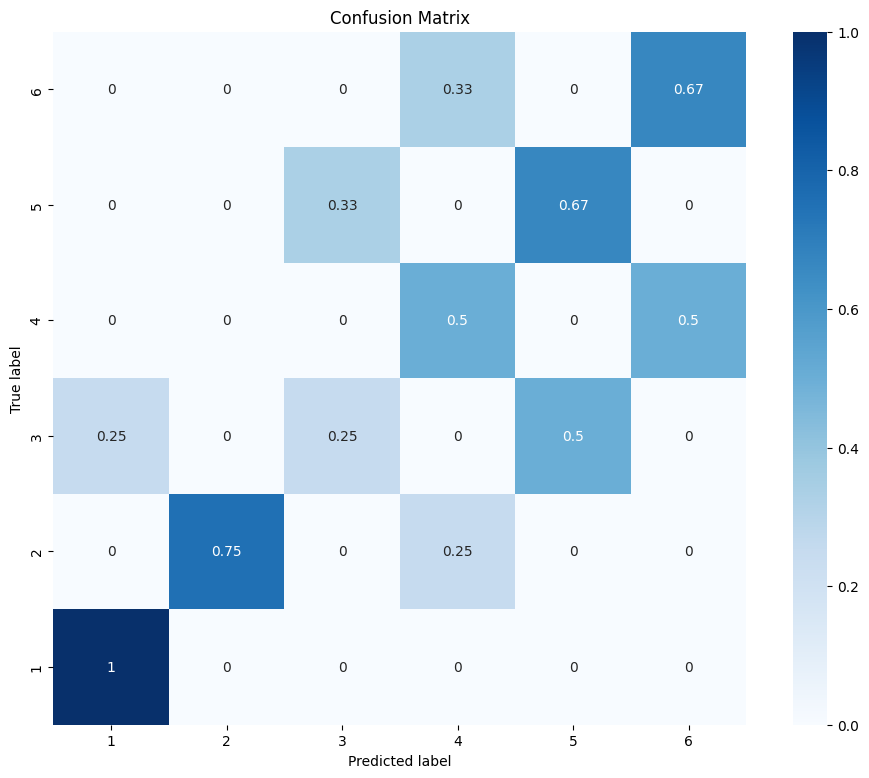

In [ ]:
# Failed pictures
# 誤認識した画像の表示(visualize.pyで定義されている)
visualize.vis_failed_pic(model, labels, validation_data, val_dir, BATCH_SIZE, 100)

# Visualize loss(損失と制度の時系列グラフを表示)
visualize.vis_loss_accuracy(history, EPOCHS)

# Save model(学習済みモデルの保存)
save_model_path = os.path.join(backup_dir, 'my_model.h5')
model.save(save_model_path)

# Confusion Matrix(混同行列の表示(ラベル数*ラベル数の行列,正解と予測が合っているかどうかひと目でわかる))
visualize.vis_confusion_matrix(model, validation_data)

Visualize filter: conv2d


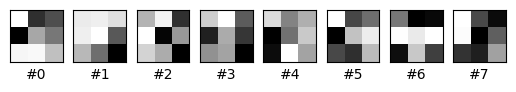

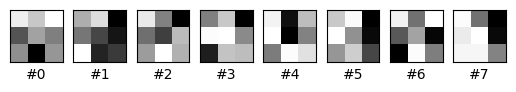

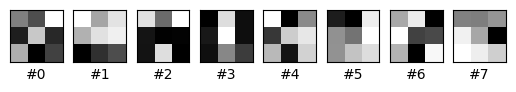

Visualize filter: conv2d_1


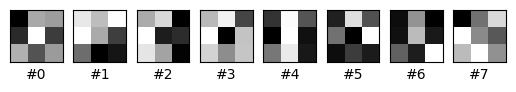

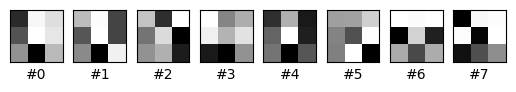

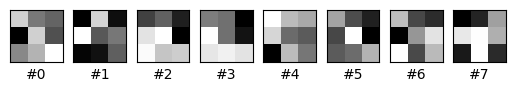

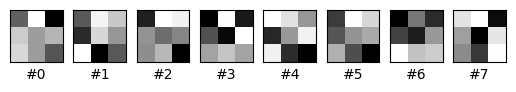

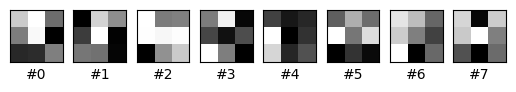

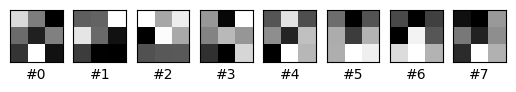

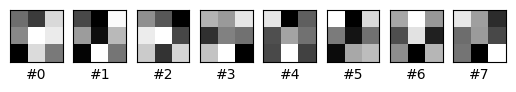

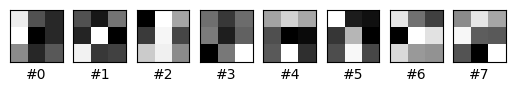

In [ ]:
visualize.vis_filter(model, 'conv2d')
visualize.vis_filter(model, 'conv2d_1')

In [ ]:
!cat incorrect.txt

target_datasets/val/3/IMG_20210418_174819.jpg
target_datasets/val/3/IMG_20210418_180647.jpg
target_datasets/val/3/IMG_20210418_180700.jpg
target_datasets/val/4/IMG_20210418_174910.jpg
target_datasets/val/4/IMG_20210418_180725.jpg
target_datasets/val/4/IMG_20210418_180742.jpg
target_datasets/val/5/IMG_20210418_174937.jpg


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 8)         224       
                                                                 
 activation (Activation)     (None, 64, 64, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 8)         584       
                                                                 
 activation_1 (Activation)   (None, 62, 62, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 8)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7688)              0         
                                                        

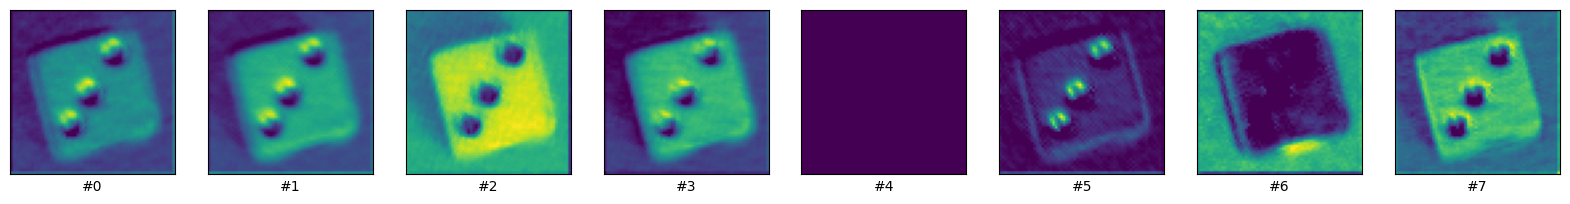

1/1 [==============================] - 0s 35ms/step
target_datasets/val/3/IMG_20210418_180647.jpg


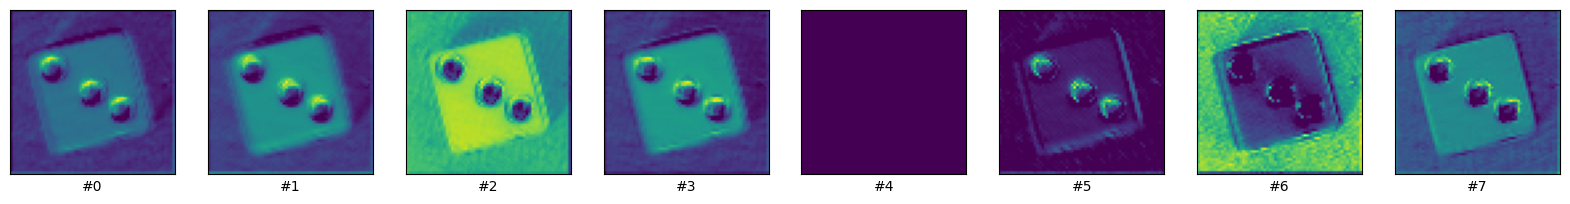

1/1 [==============================] - 0s 43ms/step
target_datasets/val/3/IMG_20210418_180700.jpg


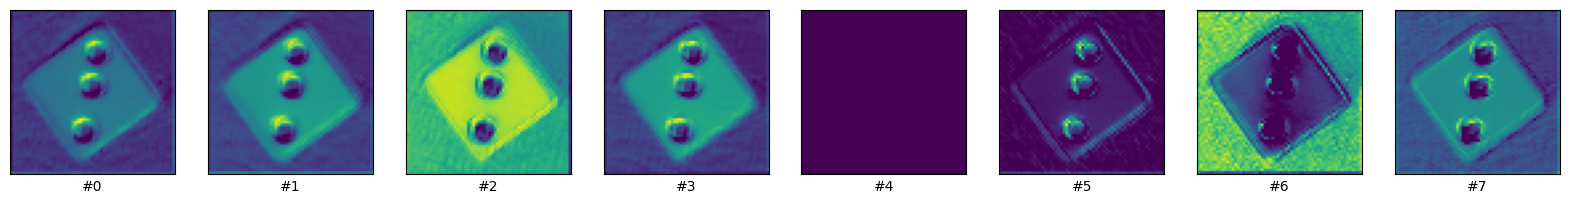

1/1 [==============================] - 0s 40ms/step
target_datasets/val/4/IMG_20210418_174910.jpg


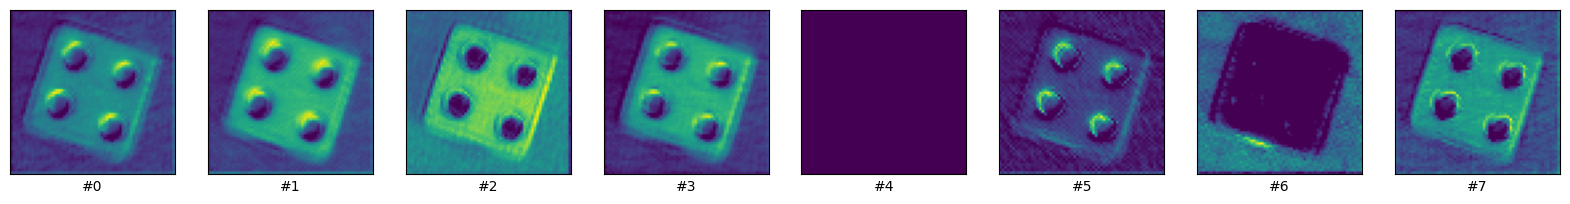

1/1 [==============================] - 0s 29ms/step
target_datasets/val/4/IMG_20210418_180725.jpg


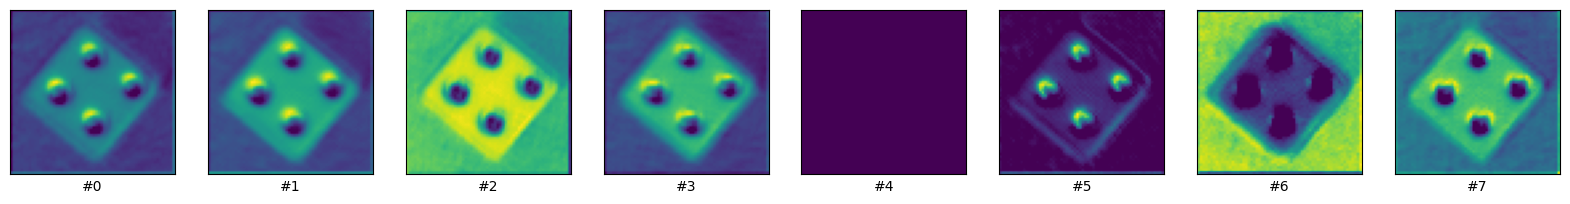

1/1 [==============================] - 0s 25ms/step
target_datasets/val/4/IMG_20210418_180742.jpg


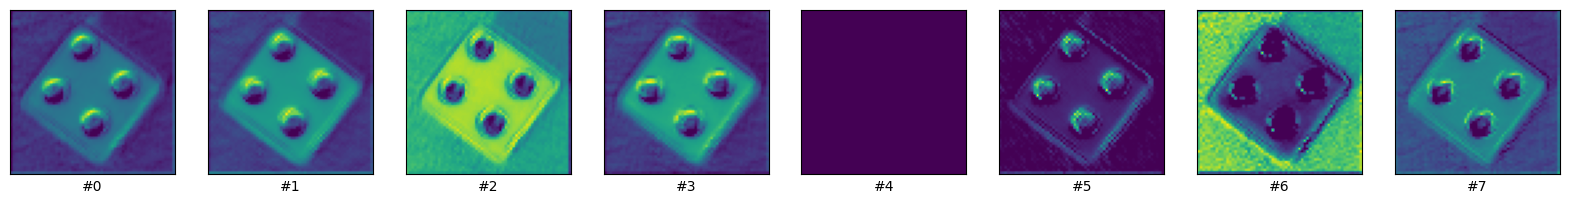

1/1 [==============================] - 0s 31ms/step
target_datasets/val/5/IMG_20210418_174937.jpg


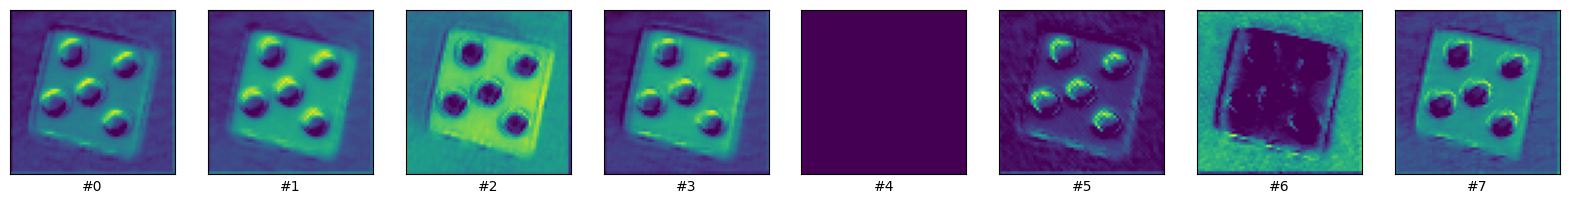

In [ ]:
visualize.vis_hidden_layer('incorrect.txt', 'activation_1', IMAGE_SIZE)